# E-Commerce Sales Prediction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

## Loading Dataset


In [3]:
df = pd.read_csv(r'C:\Users\Abhishek Panda\Downloads\e commerce dataset (1).csv', encoding='latin1')
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

## Data Cleaning and Preprocessing

In [4]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df.dropna(subset=['Order Date'], inplace=True)

# Feature extraction
df['Order_Month'] = df['Order Date'].dt.month
df['Order_Year'] = df['Order Date'].dt.year
df['Order_Weekday'] = df['Order Date'].dt.weekday

# Drop unnecessary columns
df.drop(['Country', 'Order Date'], axis=1, inplace=True, errors='ignore')

# Remove Profit values not valid for log1p()
df = df[(df['Profit'] > -1) & (df['Profit'] < 1000)]

sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)


## EDA Visualisation

### BoxPlots

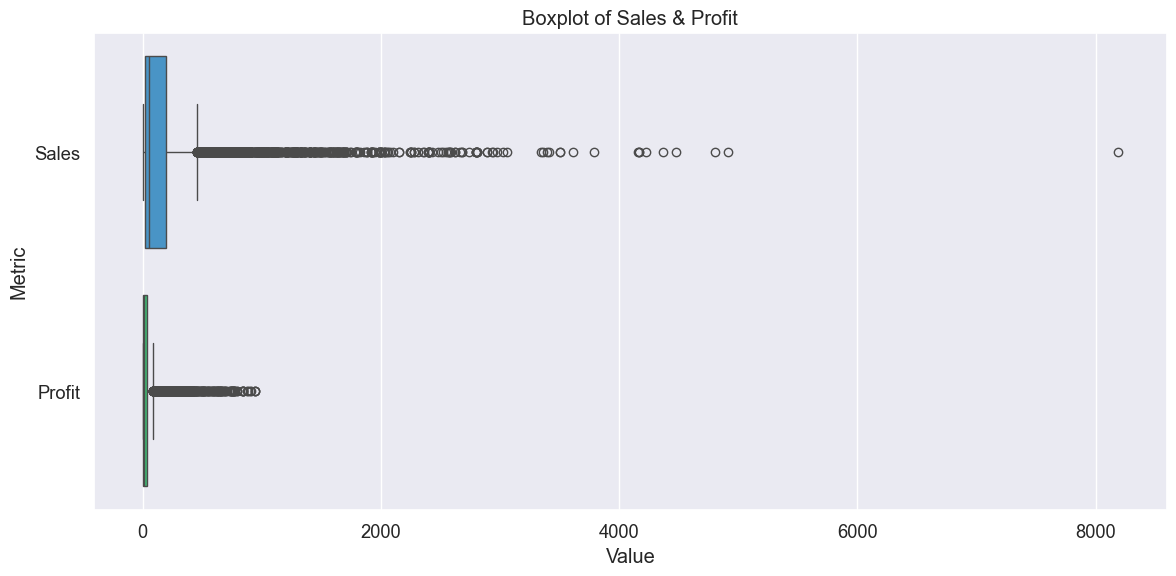

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Sales', 'Profit']].melt(var_name='Metric', value_name='Value'),
            x='Value', y='Metric', palette=["#3498db", "#2ecc71"])
plt.title("Boxplot of Sales & Profit")
plt.tight_layout()
plt.show()


### Correlation Heatmap

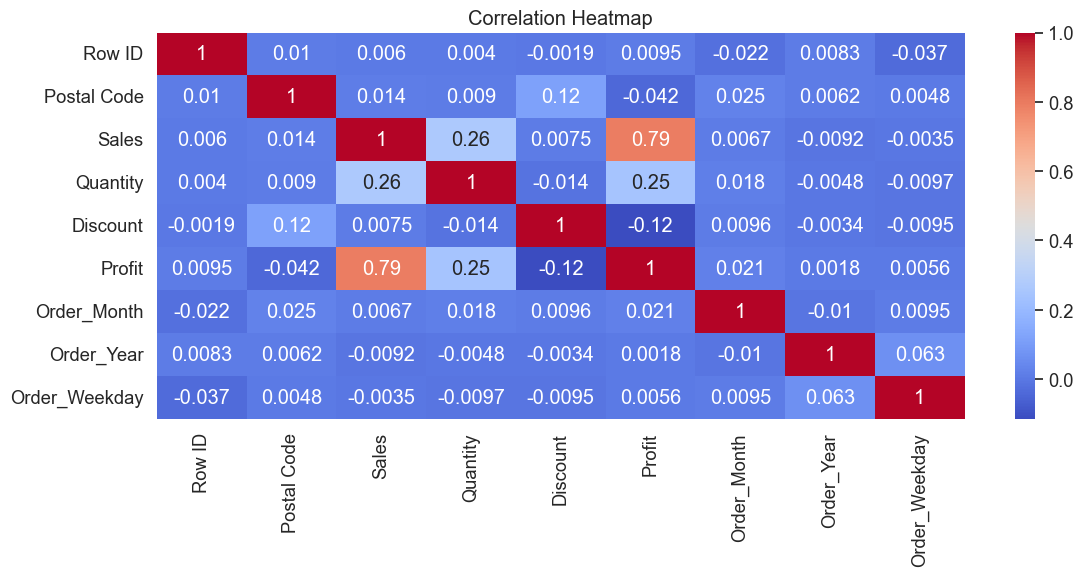

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


### Profit Histogram (Before Scaling)

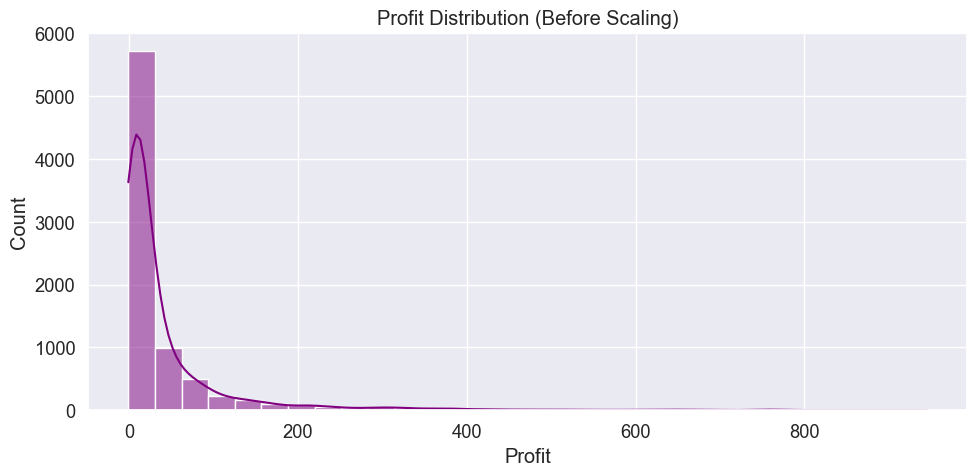

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Profit'], bins=30, kde=True, color='purple')
plt.title("Profit Distribution (Before Scaling)")
plt.tight_layout()
plt.show()


### Covariance Matrix

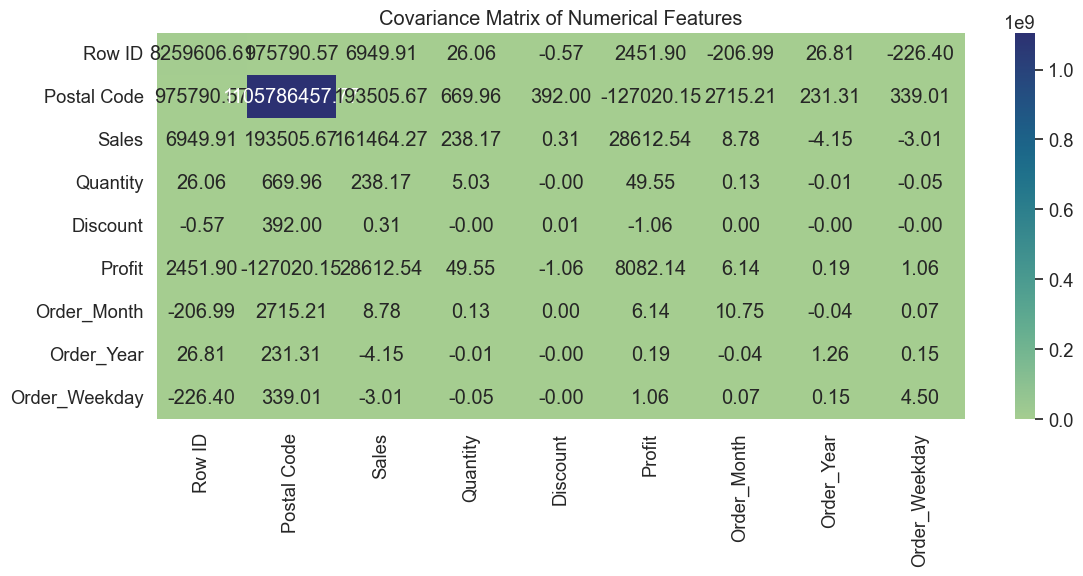

In [8]:
plt.figure(figsize=(12, 6))
cov_matrix = df.select_dtypes(include=np.number).cov()
sns.heatmap(cov_matrix, annot=True, cmap="crest", fmt=".2f")
plt.title("Covariance Matrix of Numerical Features")
plt.tight_layout()
plt.show()


### Sales vs Profit + Regression Line

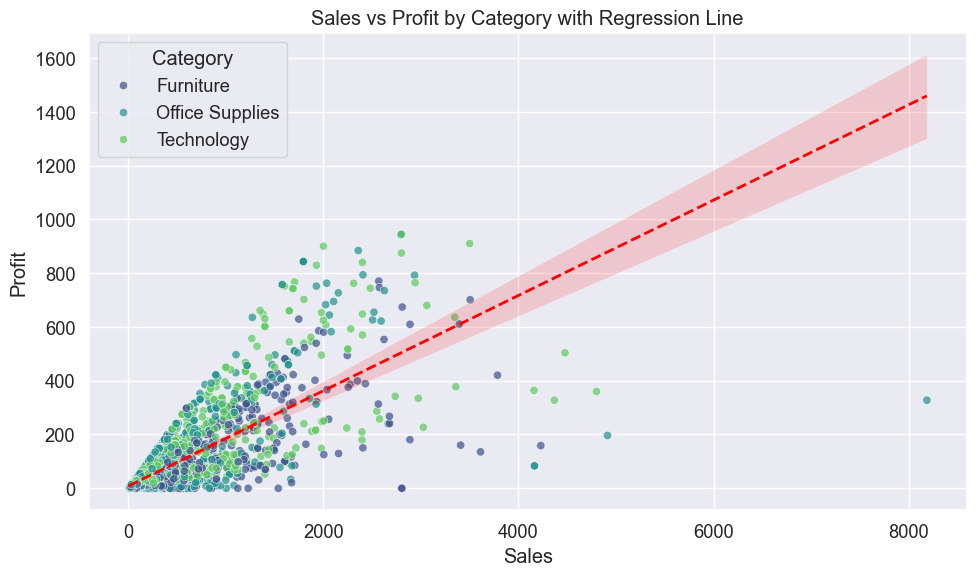

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Sales', y='Profit', hue='Category', palette='viridis', alpha=0.7)
sns.regplot(data=df, x='Sales', y='Profit', scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 2})
plt.title("Sales vs Profit by Category with Regression Line")
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()


### Total Profit by Category

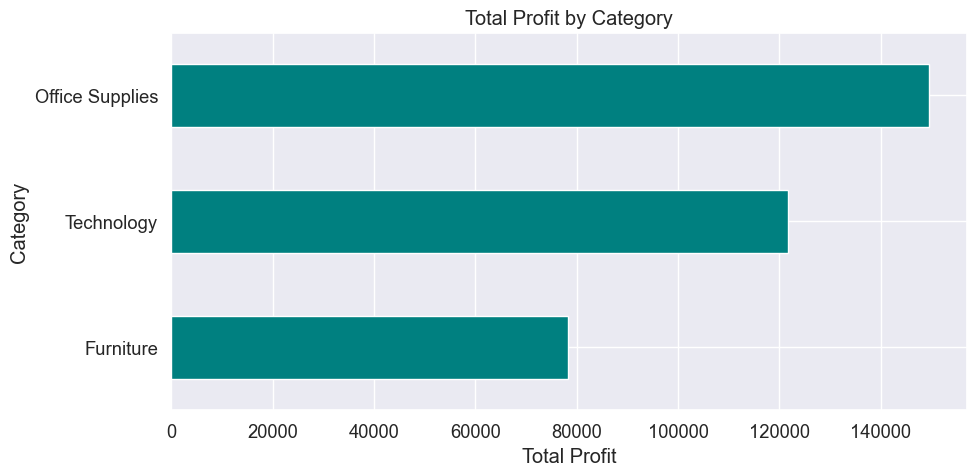

In [11]:
plt.figure(figsize=(10, 5))
category_profit = df.groupby('Category')['Profit'].sum().sort_values()
category_profit.plot(kind='barh', color='teal')
plt.title("Total Profit by Category")
plt.xlabel("Total Profit")
plt.tight_layout()
plt.show()


### Segment vs Profit Boxplot

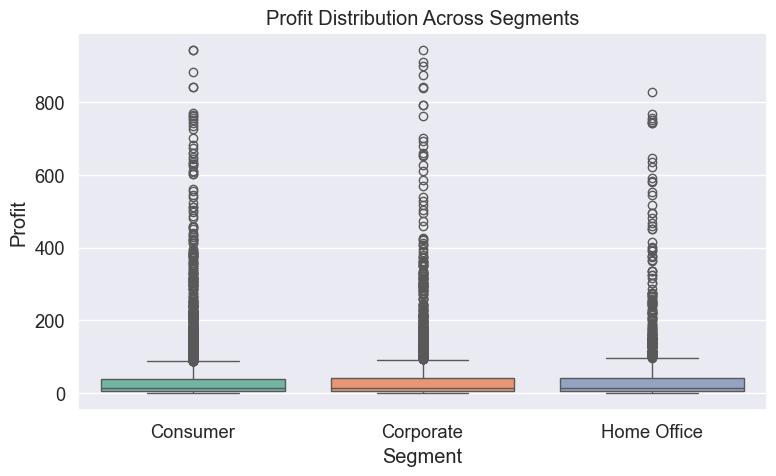

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Segment', y='Profit', data=df, palette='Set2')
plt.title("Profit Distribution Across Segments")
plt.tight_layout()
plt.show()


### Monthly Profit Trend

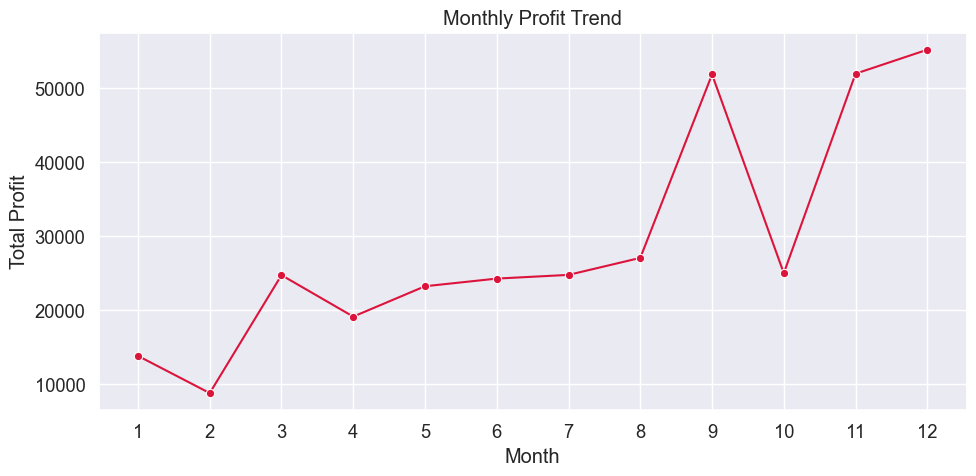

In [13]:
monthly_profit = df.groupby('Order_Month')['Profit'].sum()
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_profit.index, y=monthly_profit.values, marker='o', color='crimson')
plt.title("Monthly Profit Trend")
plt.xlabel("Month")
plt.ylabel("Total Profit")
plt.xticks(np.arange(1, 13))
plt.tight_layout()
plt.show()


### Region vs Profit Boxplot

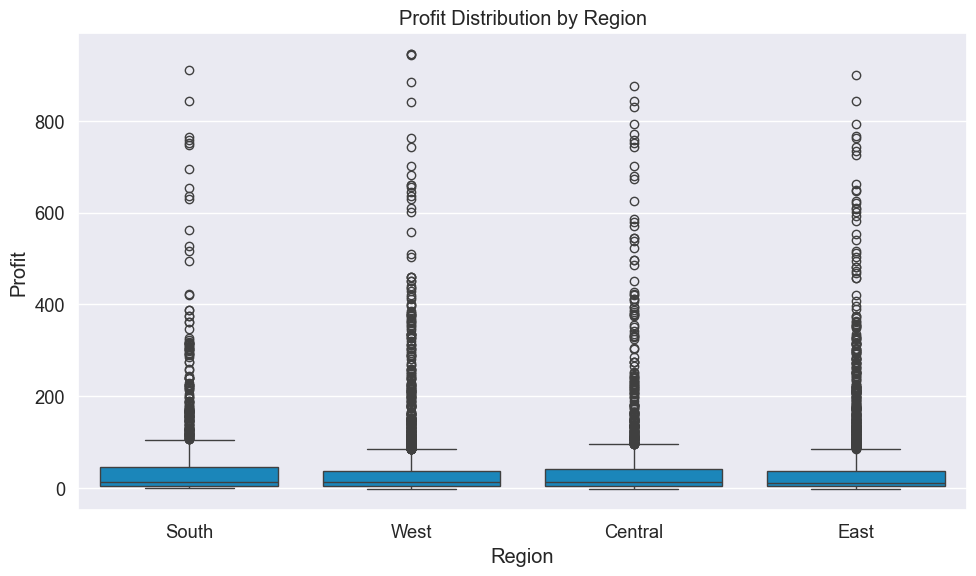

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Profit', data=df)
plt.title("Profit Distribution by Region")
plt.tight_layout()
plt.show()


## Step 4: Categorical Encoding

In [16]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


## Step 5: Features & Target Setup

In [17]:
X = df.drop('Profit', axis=1)
y_raw = df['Profit']
y = np.log1p(y_raw)  # Log transformation


## Step 6: Train-Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 7: Feature Scaling

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Step 8: Model Training (Random Forest)

In [20]:
model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
model.fit(X_train_scaled, y_train)


RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

### Step 9: Predictions (Back to Original Scale)

In [22]:
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)


### Step 10: Performance Metrics

In [23]:
r2 = r2_score(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)

print(f"✅ R² Score: {r2:.4f}")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ RMSE: {rmse:.4f}")


✅ R² Score: 0.8426
✅ MSE: 1148.2530
✅ RMSE: 33.8859


### Step 11: Feature Importance

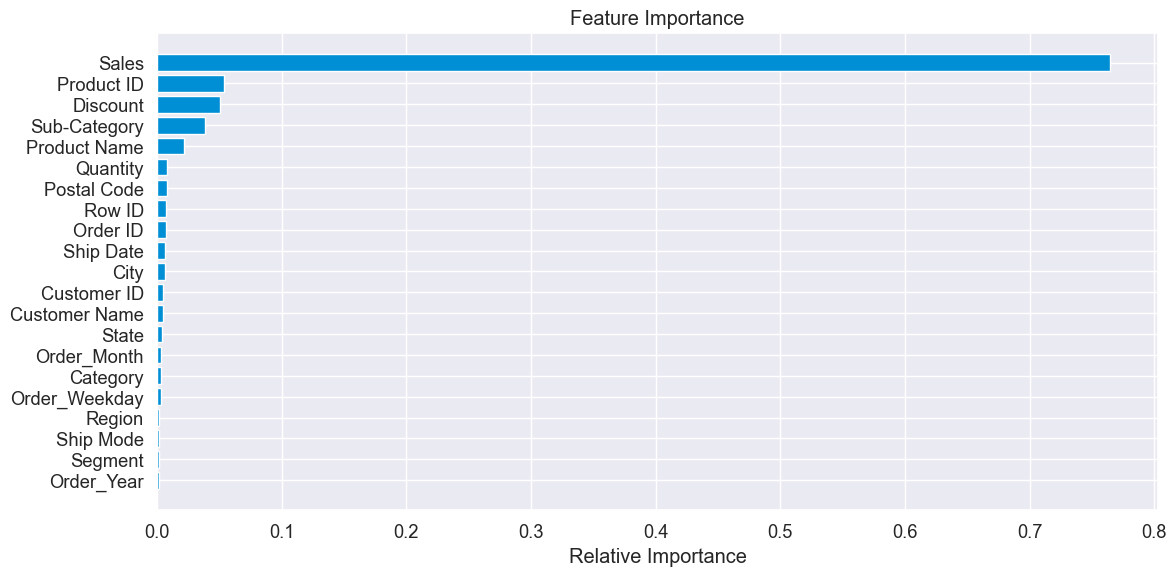

In [24]:
importances = model.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
plt.title('Feature Importance')
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), [features[i] for i in sorted_indices])
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


### Step 12: Confusion Matrix

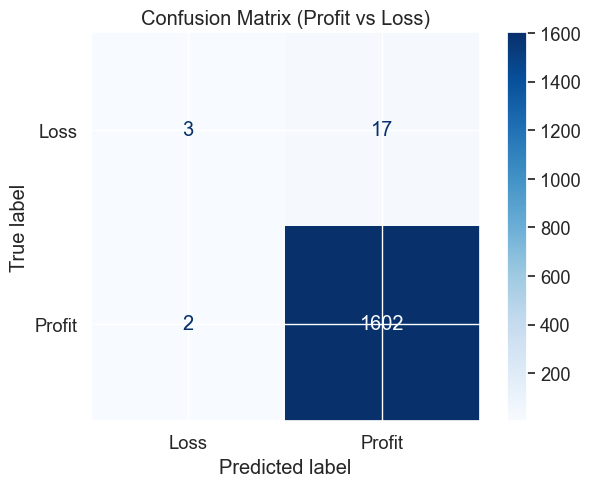

In [25]:
y_binary_actual = [1 if val > 0 else 0 for val in y_test_orig]
y_binary_pred = [1 if val > 0 else 0 for val in y_pred]

cm = confusion_matrix(y_binary_actual, y_binary_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Profit'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Profit vs Loss)")
plt.show()



## Step 13: Predicted vs Actual Histogram

### Actual Profit Histogram

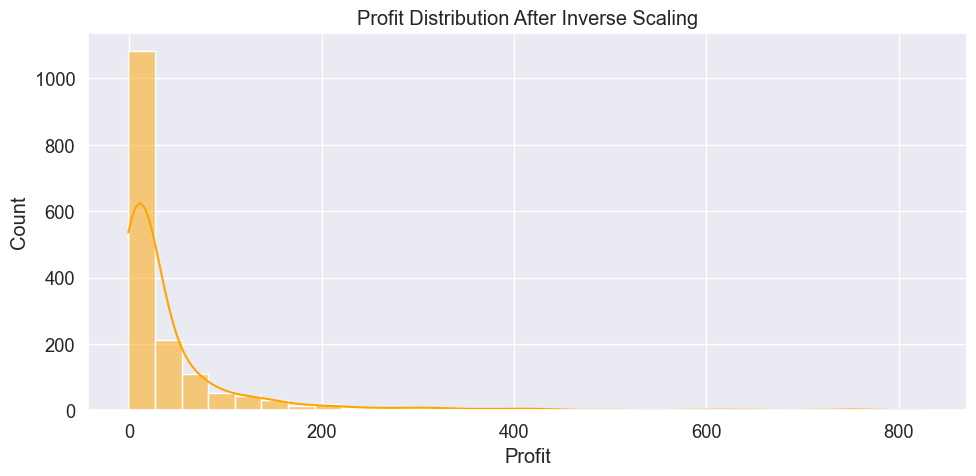

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test_orig, bins=30, color='orange', kde=True)
plt.title("Profit Distribution After Inverse Scaling")
plt.tight_layout()
plt.show()


### Predicted Profit Histogram

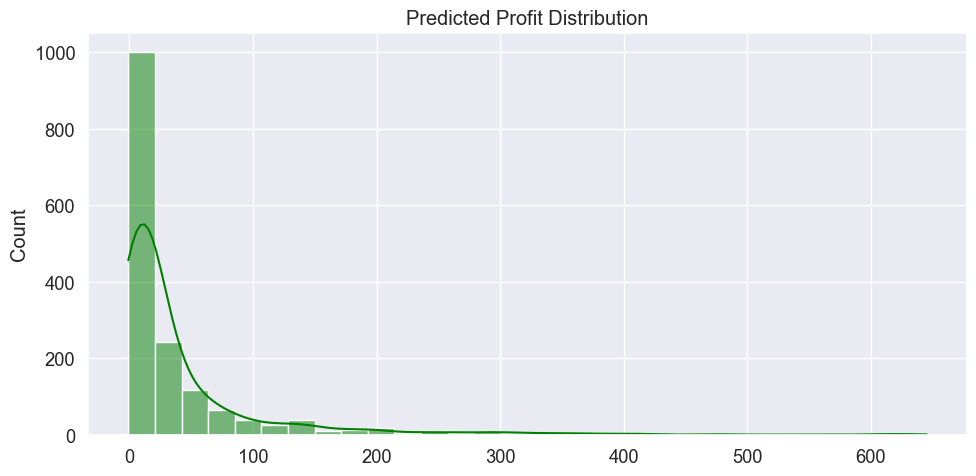

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(y_pred, bins=30, color='green', kde=True)
plt.title("Predicted Profit Distribution")
plt.tight_layout()
plt.show()
